# Clustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import plotly.express as px
from sklearn import metrics     
import plotly.figure_factory as ff

import seaborn as sns # For data visualization and specifically for pairplot()
import matplotlib.pyplot as plt # For data visualization

from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from sklearn.metrics import silhouette_score   # For Hyperparameter Tuning
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

## Utility functions

In [2]:
"""
scale the dataframe
args:
    - dataframe (DataFrame): dataframe to scale
    - scaler (Scaler, default: StandardScaler): scaler used to scale the dataframe data.
returns:
    - scaled dataframe
"""
def scale(dataframe, scaler = StandardScaler()):
    scaler.fit(dataframe)
    return scaler.transform(dataframe)

### Kmeans Functions

In [3]:


"""
apply kmeans to a dataframe 
args:
    - dataframe (DataFrame): dataframe we want to clusterize
    - n_cluster (int, default: 2): number of cluster the algorithm will produce
    - n_init (int, default: 5): number of initialization of kmeans
returns:
    - the result of kmeans
""" 

def kmeans(dataframe, n_cluster=2, n_init=5, scaler=StandardScaler()):
    km = KMeans(n_clusters=n_cluster, n_init=n_init)
    km.fit(dataframe)
    return km

"""
Returns array A s.t. A[i] is the silhouette score for kmeans using k=i and n_init=n_init
args:
    - s_dataframe (DataFrame): scaled dataframe over which apply kmeans
    - min_max_k (range): range of ks to try
    - n_init(optional, default: 2): number of initialization of kmeans 
returns: 
    dictionary with the following structure: {k: [list of used k], silhouette_scores: [silhouette scores], inertia_scores: [inerti scores]}, 
                                                i.e.: {k:[2,3], silhouette_scores:[0.43, 0.32], inertia_scores:[1.21, 2.11]}
"""
def compute_scores_kmean(s_dataframe, min_max_k, n_init=2):
    used_k = []
    silhouette_scores = []
    inertia_scores = []

    for k in min_max_k:
        model_kmeans_k = kmeans(s_dataframe, n_cluster=k, n_init=n_init)
        labels_k = model_kmeans_k.labels_
        score_k = metrics.silhouette_score(s_dataframe, labels_k)
        used_k.append(k)
        silhouette_scores.append(score_k)
        inertia_scores.append(model_kmeans_k.inertia_)
        #print("Tested kMeans with k = %d\tSS: %5.4f" % (k, score_k))
    
    return {'k': used_k, 'silhouette_scores': silhouette_scores, 'inertia_scores': inertia_scores}

"""
prints the chart that shows how silhouette_scores evolves with k. The closer to 1 it is, the better it is.
args:
    silhouette_scores (dictionary): result obtained by find_best_k function
"""
def plot_silhouette_scores(silhouette_scores):
    fig = px.line(silhouette_scores, x="k", y="silhouette_scores")
    fig.show()

"""
prints the chart that shows how inertia_scores evolves with k. The higher it is, the better it is.
args:
    inertia_scores (dictionary): result obtained by find_best_k function
"""
def plot_inertia_scores(inertia_scores):
    fig = px.line(inertia_scores, x="k", y="inertia_scores")
    fig.show()
 

example of usage:

In [4]:
"""
df = df_male_winner_stats_top
scaled_df = scale(df)

scores = compute_scores_kmean(scaled_df, range(2,30), 3)
plot_silhouette_scores(scores)
plot_inertia_scores(scores)
"""

'\ndf = df_male_winner_stats_top\nscaled_df = scale(df)\n\nscores = compute_scores_kmean(scaled_df, range(2,30), 3)\nplot_silhouette_scores(scores)\nplot_inertia_scores(scores)\n'

### DBScan 

In [5]:
"""
apply dbscan to the given dataframe
args:
    - dataframe (DataFrame): dataframe we want to clusterize
    - eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    - min_samples (int): The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.
returns:
    the result of dbscan
"""
def exec_dbscan(dataframe, eps, min_samples):
    dbscan = DBSCAN( eps = eps, min_samples = min_samples)
    return dbscan.fit(dataframe)


"""
to find optimal epsilon we calculate the distance from each point to its closest neighbour using the NearestNeighbors
args:
    - dataframe
returns array of distances
"""
def get_distances(dataframe, k=3):
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(dataframe)
    distances, indices = nbrs.kneighbors(dataframe)

    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    return distances 
    

"""
perform grid search to find best min_sample value according to silhouette scores
"""
def dbscan_grid_search(dataframe, min_samples_range, eps=0.2):
    min_samples_tried = []
    silhouette_scores = []
    for min_samples in min_samples_range:
        dbscan_result = exec_dbscan(dataframe, eps, min_samples)
        min_samples_tried.append(min_samples)
        silhouette_scores.append(metrics.silhouette_score(dataframe, dbscan_result.labels_))
    return {'min_samples': min_samples_tried, 'silhouette_scores': silhouette_scores}

"""
prints the chart that shows how silhouette_scores evolves with min samples. The closer to 1 it is, the better it is.
args:
    silhouette_scores (dictionary): result obtained by find_best_k function
"""
def plot_silhouette_scores_dbscan(silhouette_scores):
    fig = px.line(silhouette_scores, x="min_samples", y="silhouette_scores")
    fig.show()

        

### Hierarchical Clustering

In [6]:
"""
"""
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

"""
"""
def grid_search_hierarchical(dataframe, threshold_range):
    silhouette_scores = []
    thresholds = []

    for threshold in threshold_range:
        clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=threshold, linkage='complete').fit(dataframe)
        silhouette_scores.append(metrics.silhouette_score(dataframe, clustering.labels_))
        thresholds.append(threshold)
        
    return {'thresholds': thresholds, 'silhouette_scores': silhouette_scores}

"""
prints the chart that shows how silhouette_scores evolves with threshold. The closer to 1 it is, the better it is.
args:
    silhouette_scores (dictionary): result obtained by find_best_k function
"""
def plot_silhouette_scores_hierarchical(silhouette_scores):
    fig = px.line(silhouette_scores, x="thresholds", y="silhouette_scores")
    fig.show()


#  Clustering on the dataset matches_*_players

In [7]:
matches_male_players = pd.read_csv("../data/integrations/matches_male_players.csv")
matches_female_players = pd.read_csv("../data/integrations/matches_female_players.csv")

In [8]:
df_male_matches = matches_male_players[['Won_Tournaments', 'Number_of_Matches', 'Win_Percentage']]
df_female_matches = matches_female_players[['Won_Tournaments', 'Number_of_Matches', 'Win_Percentage']]

KeyError: "['Win_Percentage', 'Number_of_Matches'] not in index"

### Kmean 

#### Male players

In [ ]:
df_male_matches_scaled = scale(df_male_matches)
result = compute_scores_kmean(df_male_matches_scaled, range(2,30), 5)
plot_silhouette_scores(result)
plot_inertia_scores(result)

try with K=2 

In [ ]:
km = kmeans(df_male_matches_scaled, n_cluster=2)
labels = km.labels_
df_male_matches_scaled = pd.DataFrame(df_male_matches_scaled)
df_male_matches_scaled["cluster"] = labels 

px.scatter_3d(df_male_matches_scaled, x=0, y=1, z=2, color='cluster')

try with K=5

In [ ]:
km = kmeans(df_male_matches_scaled, n_cluster=5, n_init=30)
labels = km.labels_
df_male_matches_scaled = pd.DataFrame(df_male_matches_scaled)
df_male_matches_scaled["cluster"] = labels 

px.scatter_3d(df_male_matches_scaled, x=0, y=1, z=2, color='cluster')

#### Female players

In [ ]:
df_female_matches_scaled = scale(df_female_matches)
result = compute_scores_kmean(df_female_matches_scaled, range(2,30), 5)
plot_silhouette_scores(result)
plot_inertia_scores(result)

KeyboardInterrupt: 

try with K = 

## DBSCAN (TODO donne)

In [ ]:
#ε~=0.2
df_male_matches_scaled = scale(df_male_matches)
distances = get_distances(df_male_matches_scaled)
px.line(distances)

In [ ]:
#min_samples = 30
min_samples_to_test = range(5, 150, 5)
s = dbscan_grid_search(df_male_matches_scaled, min_samples_to_test)
plot_silhouette_scores_dbscan(s)

In [ ]:
dbscan_result = exec_dbscan(df_male_matches_scaled, eps=0.2, min_samples= 30)
labels = dbscan_result.labels_
df_male_matches_scaled = pd.DataFrame(df_male_matches_scaled)
df_male_matches_scaled["cluster"] = labels 

px.scatter_3d(df_male_matches_scaled, x=0, y=1, z=2, color='cluster')

## Hierarchical clustering

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [ ]:
from sklearn.cluster import AgglomerativeClustering
df_male_matches_scaled = scale(df_male_matches)

clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=10, linkage='complete').fit(df_male_matches_scaled)
labels = clustering.labels_
df_male_matches_scaled = pd.DataFrame(df_male_matches_scaled)
df_male_matches_scaled["cluster"] = labels 

px.scatter_3d(df_male_matches_scaled, x=0, y=1, z=2, color='cluster')

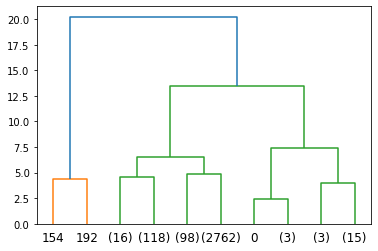

In [ ]:
plot_dendrogram(clustering, truncate_mode="level", p=3)

In [ ]:
result = grid_search_hierarchical(df_male_matches_scaled, np.arange(0.1, 15.0, 0.1))
plot_silhouette_scores_hierarchical(result)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:1677: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:1677: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:1677: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:1677: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/shared-libs/python3.7/py/lib/python3.7/site

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=de87b132-0371-4d99-94f9-c61923e2507d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>